### Goal: 
to predict motion based on time series data for various motion types

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/motionsense-dataset/data_subjects_info.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/__MACOSX/A_DeviceMotion_data/wlk_7/._sub_13.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/__MACOSX/A_DeviceMotion_data/jog_9/._sub_5.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/__MACOSX/A_DeviceMotion_data/jog_9/._sub_4.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/__MACOSX/A_DeviceMotion_data/dws_1/._sub_1.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/wlk_7/sub_13.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/wlk_7/sub_4.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/wlk_7/sub_21.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/wlk_7/sub_15.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/wlk_7/sub_12.csv
/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/wlk_7/sub_

Load the subject csv file

In [15]:
pd_subjects = pd.read_csv('/kaggle/input/motionsense-dataset/data_subjects_info.csv')
pd_subjects.head()

,code,weight,height,age,gender
0,1,102,188,46,1
1,2,72,180,28,1
2,3,48,161,28,0
3,4,90,176,31,1
4,5,48,164,23,0


In [16]:
pd_subjects.shape

(24, 5)

As the instruction file mentioned, there are 6 motion types:

1. dws: downstairs
2. ups: upstairs
3. sit: sitting
4. std: standing
5. wlk: walking
6. jog: jogging

In [17]:
motion_types = ["dws", "ups", "sit", "std", "wlk", "jog"]

import glob

# Loop through motion types
for motion in motion_types:
    
    # Just list one for testing
    if (motion=='dws'):
        file_long = "/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/" + motion + "_[0-9]/*.csv"
        file_short = "/kaggle/input/motionsense-dataset/A_DeviceMotion_data/A_DeviceMotion_data/" + motion + "_1[0-9]/*.csv"

        files_long = glob.glob(file_long)
        files_short = glob.glob(file_short)

Looking at one of the subjects as a test:

In [18]:
pd_test = pd.read_csv(files_short[0], index_col = 0)
pd_test.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-2.365592,-0.983627,2.827615,-0.388043,0.832512,0.395406,0.210245,0.173495,0.739084,-0.009266,-0.456978,-1.203618
1,-2.368891,-1.003868,2.824685,-0.374895,0.843554,0.384538,0.958999,-0.108221,0.743606,0.226030,0.004926,-1.080720
2,-2.370299,-1.031715,2.839498,-0.357836,0.858181,0.368075,1.405588,-1.194071,0.706457,0.263918,0.046055,-0.916949
3,-2.381487,-1.067798,2.859145,-0.332134,0.876141,0.349375,1.780489,-1.249950,1.034955,0.104717,0.308780,-0.332514
4,-2.374319,-1.108792,2.883151,-0.309424,0.895161,0.320849,1.800099,-0.384313,0.859862,-0.303430,0.477047,-0.051684


Plot to see what it looks like

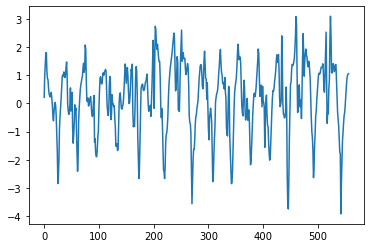

In [19]:
plt.plot(pd_test['rotationRate.x'])

An idea:
- analyze the time series data with ARIMA techniques
- feed the components into neural network to identify the motion

In [20]:
from statsmodels.api import tsa

pd_test.head()

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-2.365592,-0.983627,2.827615,-0.388043,0.832512,0.395406,0.210245,0.173495,0.739084,-0.009266,-0.456978,-1.203618
1,-2.368891,-1.003868,2.824685,-0.374895,0.843554,0.384538,0.958999,-0.108221,0.743606,0.226030,0.004926,-1.080720
2,-2.370299,-1.031715,2.839498,-0.357836,0.858181,0.368075,1.405588,-1.194071,0.706457,0.263918,0.046055,-0.916949
3,-2.381487,-1.067798,2.859145,-0.332134,0.876141,0.349375,1.780489,-1.249950,1.034955,0.104717,0.308780,-0.332514
4,-2.374319,-1.108792,2.883151,-0.309424,0.895161,0.320849,1.800099,-0.384313,0.859862,-0.303430,0.477047,-0.051684


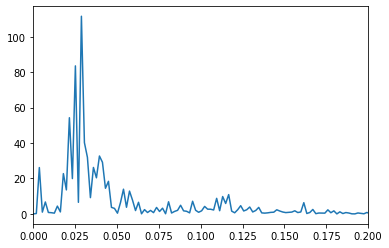

Maximum on periodogram: 111.52429178839319 at 0.02872531418312388


In [25]:
from scipy.signal import periodogram

# Decompose the time series
ts_rotationRate_x = pd_test['rotationRate.x']
f, PSD = periodogram(ts_rotationRate_x)

# Show the periodogram
plt.plot(f, PSD)
plt.xlim([0, 0.2])
plt.show()

print(f'Maximum on periodogram: {max(PSD)} at {f[np.argmax(PSD)]}')

In [32]:
# Get the peak from the periodogram
# Then infer periodicity
period_rotationRate_x = int(1/f[np.argmax(PSD)])

dc_rotationRate_x = tsa.seasonal_decompose(ts_rotationRate_x, model='additive', period = period_rotationRate_x)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

<Figure size 1008x720 with 0 Axes>

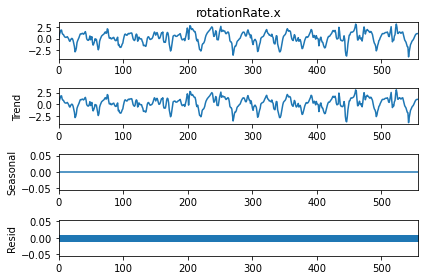

In [31]:
plt.figure(figsize=(14,10))
dc_rotationRate_x.plot()
plt.show()